In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Flickr_sample/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##dataloader
## vocab
## create model
## train
## validation

In [0]:
import torch
import nltk
nltk.download('punkt')
from imageio import imread
from PIL import Image
import torch.nn as nn
import math
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from skimage.io import imread
from skimage.transform import resize
from torch.nn.utils.rnn import pack_padded_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
image_ids = os.listdir('Flicker8k_Dataset')
## lower all the sentences
with open('Flickr8k.token.txt', 'r') as f:
  w = f.readlines()
w_dict = {}
for l in w:
  if l.split('#')[0] in list(w_dict.keys()):
    w_dict[l.split('#')[0]].append(l.split('#')[1][3:-4])
  else:
    w_dict[l.split('#')[0]] = [l.split('#')[1][3:-4]]

image_ids = [ids for ids in image_ids if ids in list(w_dict.keys())]
valid_size = 0.2
train_ids = image_ids[:math.floor(len(image_ids)*valid_size)]
valid_ids = image_ids[math.floor(len(image_ids)*valid_size):]

In [0]:
##vocab
vocab = {}
for li in w_dict.values():
  for sen in li:
    for word in sen.split(' '):
      if word not in vocab:
        vocab[word] = 1
      else:
        vocab[word] += 1
words = [word for word, count in vocab.items() if count >= 5]

In [0]:
class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.id2word = {}
    self.idx = 0
  
  def add_word(self, word):
    if word not in self.word2idx:
      self.word2idx[word] = self.idx
      self.id2word[self.idx] = word
      self.idx += 1
  
  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]
  
  def __len__(self):
    return len(self.word2idx)

In [0]:
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')
for word in words:
  vocab.add_word(word)

In [0]:
class ImagecaptionDataset(data.Dataset):
  def __init__(self,root,vocab, image_ids, text, transform = None):
    self.image_ids = image_ids
    self.text = text
    self.vocab = vocab
    self.transform = transform
    self.root = root
  def __getitem__(self, index):
    img = self.image_ids[index]
    caption = self.text[img][0]
    image = Image.open(self.root +img).convert('RGB')
    image = image.resize((256, 256))

    if self.transform is not None:
      image = self.transform(image)
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    caption = []
    caption.append(self.vocab('<start>'))
    caption.extend([self.vocab(cap) for cap in tokens])
    caption.append(self.vocab('<end>'))

    target = torch.Tensor(caption)

    return image, target
  
  def __len__(self):
    return len(self.image_ids)

In [0]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
      end = lengths[i]
      targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [0]:
def get_loader(root, vocab,  image_ids,text, batch_size, shuffle, num_workers, transform):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    flickr = ImagecaptionDataset(root,vocab, image_ids, text, transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=flickr, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

For the encoder part, the pretrained CNN extracts the feature vector from a given input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the LSTM network. For the decoder part, source and target texts are predefined. For example, if the image description is "Giraffes standing next to each other", the source sequence is a list containing ['<start>', 'Giraffes', 'standing', 'next', 'to', 'each', 'other'] and the target sequence is a list containing ['Giraffes', 'standing', 'next', 'to', 'each', 'other', '<end>']. Using these source and target sequences and the feature vector, the LSTM decoder is trained as a language model conditioned on the feature vector.

In [0]:
#for (images, captions, lengths) in dataloader:
# en = EncoderCNN(256).to(device)
# images = images.to(device)
# fe = en(images)
# de = DecoderLSTM(len(vocab), 256, 512, 2, max_seq_length=20).to(device)
# captions = captions.to(device)
# outputs, embeddings, embeddings_1, packed, hiddens = de(fe, captions, lengths)

In [0]:
# print(fe.shape)
# print(embeddings.shape)
# print(embeddings_1.shape)
# packed[0].shape
# hiddens[0].shape
# outputs.shape

In [0]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    resnet = models.resnet152(pretrained=True)
    modules = nn.Sequential(*list(resnet.children())[:-1])
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features, embed_size)
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
  
  def forward(self, images):
    with torch.no_grad():
      features = self.resnet(images)
    features = features.reshape(features.size(0), -1)
    features = self.bn(self.linear(features))
    return features


class DecoderLSTM(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, max_seq_length=20):
    super(DecoderLSTM, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.LSTM = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length
  
  def forward(self, features, captions, lengths):
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
    packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
    hiddens, _ = self.LSTM(packed)
    outputs = self.linear(hiddens[0])
    return outputs
 
  def sample(self, features, states=None):
    """Generate captions for given image features using greedy search."""
    sampled_ids = []
    inputs = features.unsqueeze(1)
    for i in range(self.max_seq_length):
      hiddens, states = self.LSTM(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
      outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
      _, predicted = outputs.max(1)                        # predicted: (batch_size)
      sampled_ids.append(predicted)
      inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
      inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
    sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
    return sampled_ids

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
embed_size = 1024
hidden_size = 256
num_layers = 1
lr = 0.0001
num_epochs = 20
log_step = 5
batch_size=32
root = 'Flicker8k_Dataset/'
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])
    

# Build data loader
train_dataloader = get_loader(root, vocab,  train_ids,w_dict, batch_size, True,1, transform = transform) 
valid_dataloader = get_loader(root, vocab,  valid_ids,w_dict, batch_size, True,1, transform = transform)
# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(len(vocab), embed_size, hidden_size, num_layers).to(device)
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=lr)
    
# Train the models
#total_step = len(dataloader)
for epoch in range(num_epochs):
  encoder.train()
  decoder.train()
  train_loss = 0
  valid_loss = 0
  for i, (images, captions, lengths) in enumerate(train_dataloader):

    # Set mini-batch dataset
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    # Forward, backward and optimize
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    train_loss += loss.item()
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    ## validation
  encoder.eval()
  decoder.eval()
  for j, (images_, captions_, lengths_) in enumerate(valid_dataloader):

    # Set mini-batch dataset
    images_ = images_.to(device)
    captions_ = captions_.to(device)
    targets_ = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]

    # Forward, backward and optimize
    features_ = encoder(images_)
    outputs_ = decoder(features_, captions_, lengths_)
    valid_los = criterion(outputs_, targets_)
    valid_loss += valid_los.item()


    # Print log info
   # if i % log_step == 0:
  print('Epoch [{}/{}], train_Perplexity: {:5.4f}, valid_perplexity: {:5.4f}'
              .format(epoch, num_epochs, np.exp(train_loss/i), np.exp(valid_loss/j)))

Epoch [0/20], train_Perplexity: 3304.9065, valid_perplexity: 2296.4918
Epoch [1/20], train_Perplexity: 1199.4010, valid_perplexity: 436.2897
Epoch [2/20], train_Perplexity: 236.7451, valid_perplexity: 190.0847
Epoch [3/20], train_Perplexity: 145.2892, valid_perplexity: 142.2395
Epoch [4/20], train_Perplexity: 112.0890, valid_perplexity: 115.3247
Epoch [5/20], train_Perplexity: 91.9562, valid_perplexity: 98.2269
Epoch [6/20], train_Perplexity: 78.7227, valid_perplexity: 87.9283
Epoch [7/20], train_Perplexity: 69.3907, valid_perplexity: 80.0796
Epoch [8/20], train_Perplexity: 62.9233, valid_perplexity: 75.6011
Epoch [9/20], train_Perplexity: 57.2498, valid_perplexity: 71.3627
Epoch [10/20], train_Perplexity: 52.8450, valid_perplexity: 67.5600
Epoch [11/20], train_Perplexity: 48.8768, valid_perplexity: 66.0990
Epoch [12/20], train_Perplexity: 45.6461, valid_perplexity: 63.1333
Epoch [13/20], train_Perplexity: 42.9126, valid_perplexity: 60.3116
Epoch [14/20], train_Perplexity: 40.5091, val

black dog is running on a <unk>


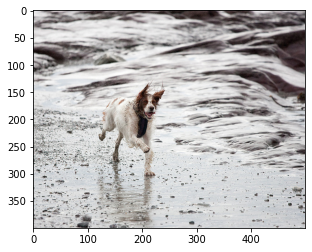

In [0]:
idx = 2000
img = 'Flicker8k_Dataset/'+ image_ids[idx]
img = imread(img)
plt.imshow(img)
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
#img = resize(img, (256, 256))
img = img.transpose(2, 0, 1)
img = img / 255.
img = torch.FloatTensor(img).to(device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])
image = transform(img)  # (3, 256, 256)

features = encoder(image.unsqueeze(0))
ids = decoder.sample(features)
wds = []
for id_ in ids.tolist()[0]:
  if vocab.id2word[id_] != "<start>" and vocab.id2word[id_] != "<end>":
    wds.append(vocab.id2word[id_])
print(' '.join(wd for wd in wds))

In [0]:
## why is resize affecting sampling 